<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

Linear Regression is a simple and very common regression method. In this post, we try to grab the popular python packages and verify whether they can produce same results.

The following methods are used
 * sklearn Linear Regressor
 * Statmodels (https://www.statsmodels.org/stable/regression.html)
 * SPARK ML
 * TensorFlow
   * Single-layer
   * Multi-layers

For the set of *boston house*, results from sklearn, statmodel, Spark ML matches exactly. Single-layer Neural Network is able to give very similar coefficients. Interesting, a "randomly" designed Multu-layers Neural Network is able to create a model with much better R2 score. 

## DataSet Preparation (Boston Data)

In [0]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.datasets import load_boston
boston = load_boston()
df_x = pd.DataFrame(boston.data, columns = boston.feature_names)
df_y = pd.DataFrame(boston.target)
df_x.describe()

#Split the data into 80% training and 20% testing data
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

x_train_columns = list(x_train.columns)

from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler( )
x_train_np = scaler.fit_transform( x_train ) #fit and then transform
x_test_np  = scaler.transform ( x_test )     #transform

x_train = pd.DataFrame(x_train_np,  columns=x_train.columns)
x_test  = pd.DataFrame(x_test_np,  columns=x_train.columns)

# Some algorithm may prefer scaled data

### By LinearRegression from sklearn

regression cooefficients:

     feature       coef
0   intecept  22.970796
1       CRIM  -0.988580
2         ZN   0.867933
3      INDUS   0.405028
4       CHAS   0.861838
5        NOX  -1.900100
6         RM   2.808135
7        AGE  -0.358669
8        DIS  -3.045535
9        RAD   2.032761
10       TAX  -1.364009
11   PTRATIO  -2.082536
12         B   1.041257
13     LSTAT  -3.926286

The model performance for  training  set
--------------------------------------
RMSE is 4.794269062151269
R2 score is 0.7392344370995025

The model performance for  testing  set
--------------------------------------
RMSE is 4.552364598463061
R2 score is 0.7261570836552478


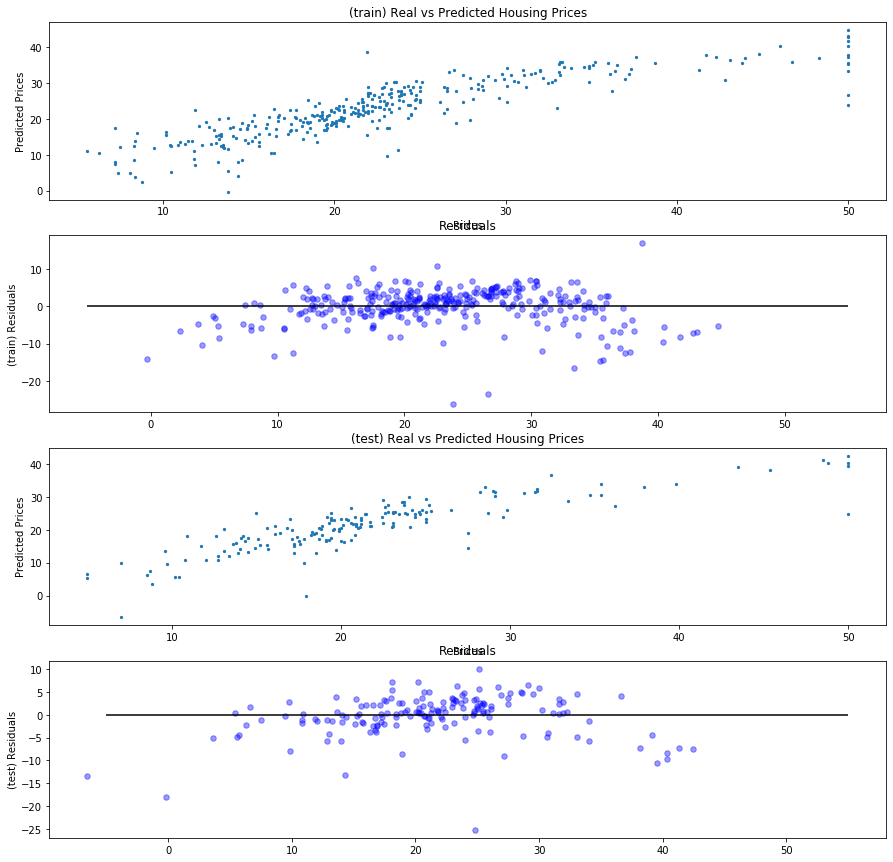

In [11]:

#Initialize the linear regression model
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

#Print the coefecients/weights for each feature/column of our model
coefDataFrame = pd.DataFrame( zip( ["intecept"] +  x_train_columns, 
                                   list(lin_model.intercept_) + list(lin_model.coef_.flatten())),
                              columns=['feature', 'coef'])

print("regression cooefficients:\n")
print(coefDataFrame)

def linear_Reg_report(dataset_type, predict_Y, actual_Y):
    rmse = (np.sqrt(mean_squared_error(actual_Y, predict_Y)))
    r2 = r2_score(actual_Y, predict_Y)

    print("\nThe model performance for ",  dataset_type, " set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))


y_train_predict = lin_model.predict(x_train)
y_test_predict =  lin_model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.scatter( y_train, y_train_predict, s=5 )
plt.xlabel( "Prices")
plt.ylabel( "Predicted Prices")
plt.title( "(train) Real vs Predicted Housing Prices")

plt.subplot(4, 1, 2)
plt.scatter( y_train_predict, y_train_predict - y_train,
c ='b', s=30, alpha=0.4 )
plt.hlines( y=0, xmin=-5, xmax=55)
plt.title( "Residuals" )
plt.ylabel( "(train) Residuals" )

plt.subplot(4, 1, 3)
plt.scatter( y_test, y_test_predict, s=5 )
plt.xlabel( "Prices")
plt.ylabel( "Predicted Prices")
plt.title( "(test) Real vs Predicted Housing Prices")

plt.subplot(4, 1, 4)
plt.scatter( y_test_predict, y_test_predict - y_test,
c ='b', s=30, alpha=0.4 )
plt.hlines( y=0, xmin=-5, xmax=55)
plt.title( "Residuals" )
plt.ylabel( "(test) Residuals" )
plt.show()


plt.show()

### By Statmodels

In [9]:

import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices

X = sm.add_constant(x_train) # adding a constant

sm_model = sm.OLS(y_train.values, X).fit()
sm_model_summary = sm_model.summary()
print(sm_model_summary)

sm_params = pd.DataFrame(
     {"feature": ["intecept"] +  x_train_columns, 
       "coef"  : sm_model.params.values
     },
     columns=['feature', 'coef'])

    
print(sm_params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     70.87
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.49e-86
Time:                        03:02:42   Log-Likelihood:                -1012.4
No. Observations:                 339   AIC:                             2053.
Df Residuals:                     325   BIC:                             2106.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9708      0.266     86.376      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### By Spark ML

install pyspark library

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

#package to add PySpark to sys.path at runtime
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init() 

In [0]:
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.context import SparkContext

globs = globals()
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
sc = spark.sparkContext

#import data from previuos session, x_train, x_test, y_train, y_test
xx_train =  x_train.copy()
xx_train["Y"] = y_train.values
xx_test =  x_test.copy()
xx_test["Y"] = y_test.values

x_train_sp = spark.createDataFrame(xx_train)
x_test_sp  = spark.createDataFrame(xx_test)

##### INPUT FOR SPARK
# Spark ML’s algorithms expect the data to be represented in two columns: Features and Labels. 
# 1. Features is an array of data points of all the features to be used for prediction. 
# 2. Labels contain the output label for each data point.

# To create a features array, import the VectorAssembler class and pass in a list of the feature column names.
from pyspark.ml.feature import VectorAssembler
feature_columns = x_train_sp.columns[:-1]   # do not include "Y" column (which is the last one)
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
x_train_sp = assembler.transform(x_train_sp)
#x_train_sp["label"] = y_train.values
print(x_train_sp.show(5))

from pyspark.ml.regression import LinearRegression
# Defining the algorithm variable. We need to specify the name of the features column and the labels column.
algorithm = LinearRegression(featuresCol="features", labelCol="Y")

model_spark = algorithm.fit(x_train_sp)

print("Intercept", model_spark.intercept, "\n",
      "Coefficient: ", model_spark.coefficients)


# Evaluating Model Performance
x_test_sp = assembler.transform(x_test_sp)

evaluation_summary = model_spark.evaluate(x_train_sp)
print("TRAINING ------------------------------------")
print("MAE: ", evaluation_summary.meanAbsoluteError)
print("RMSE: ", evaluation_summary.rootMeanSquaredError)
print("R2: ", evaluation_summary.r2)

evaluation_summary = model_spark.evaluate(x_test_sp)
print("TESTING -------------------------------------")
print("MAE: ", evaluation_summary.meanAbsoluteError)
print("RMSE: ", evaluation_summary.rootMeanSquaredError)
print("R2: ", evaluation_summary.r2)


+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+----+--------------------+
|                CRIM|                 ZN|               INDUS|                CHAS|                 NOX|                  RM|               AGE|                DIS|                RAD|                 TAX|            PTRATIO|                  B|               LSTAT|   Y|            features|
+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+----+--------------------+
|  0.8962487154968979|-0.5106013881354163|   0.982782232206114|-0.28821362329313566| 0.48083147770775053|-0.1977673372

### Using Tensorflow

#### Single layer network. 
This one should be in theory same as the linear regression.

However since we need to specify the learning rate and epoch, we can only get the coefficients very close to the coefficients from the above methods.

2.1.0

..........
..........
..........
..........
..........
..........
....6323


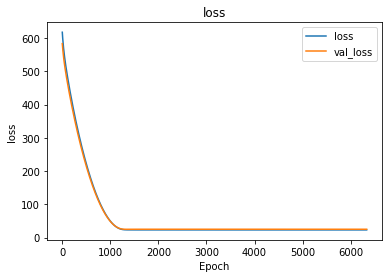

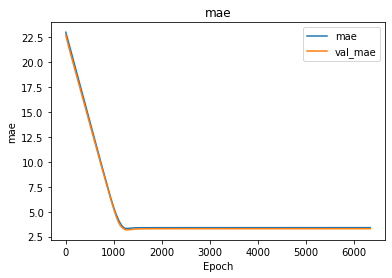

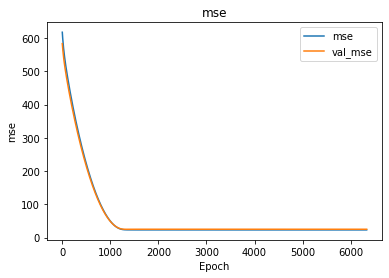

339/339 [==============================] - 0s 43us/sample - loss: 23.2693 - mae: 3.3745 - mse: 23.2693
Train :evaluate score =  [23.26926042899973, 3.3745215, 23.26926]
167/167 [==============================] - 0s 60us/sample - loss: 21.9838 - mae: 3.2699 - mse: 21.9838
Test :evaluate score =  [21.983775955474304, 3.269892, 21.983778]

The model performance for  training  set
--------------------------------------
RMSE is 4.823822133373913
R2 score is 0.7360096804949456

The model performance for  testing  set
--------------------------------------
RMSE is 4.688685998302498
R2 score is 0.7095109712987798

the coefficient is as the following:
[[-1.0209309 ]
 [ 0.87147653]
 [ 0.47828507]
 [ 0.7215416 ]
 [-1.6400989 ]
 [ 2.5242193 ]
 [-0.10171466]
 [-2.7003927 ]
 [ 1.691111  ]
 [-1.1543294 ]
 [-2.0122602 ]
 [ 1.1727936 ]
 [-4.508147  ]]
Bias:  [22.928215]


In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
                                                     
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 1000 == 0: print('')
    if epoch % 100 == 0: print(".", end='')

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

widthX = x_train.shape[1]
#build our model
model = Sequential([
    Dense(1, input_shape=(widthX,), use_bias=True)
   ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002) # Default value
model.compile(optimizer=optimizer,loss='mse', metrics =['mae', 'mse'])

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=10000,
    shuffle=False,
    validation_split = 0.2,
    verbose=0, callbacks=[early_stop, PrintDot()]
)

minepoch = np.argmin(history.history["loss"])
print(minepoch)

def print_coeff():
  print("\nthe coefficient is as the following:")
  for trainable_variable in model.trainable_weights:
    name = trainable_variable.name
    values =  trainable_variable.read_value().numpy()
    if ("/bias:" in name):
      print("Bias: ", values)
    else:
      print(values)

def plot_Tesor(history, ylabel):
  import matplotlib.pyplot as plt
  plt.clf()
  for k in history.keys():
    if k.endswith(ylabel):
      plt.plot(history[k], label=k)
  plt.title(ylabel)
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_Tesor(history.history, "loss")
plot_Tesor(history.history, "mae")
plot_Tesor(history.history, "mse")

def model_sum(model, X, Y, Title="Train"):
  score = model.evaluate(X, Y)
  print(Title, ":evaluate score = ", score)

model_sum(model, x_train, y_train, "Train")
model_sum(model, x_test,  y_test,  "Test")

y_train_predict = model.predict(x_train)
y_test_predict =  model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

print_coeff()

#### Multi-layers

This is fun part. As you can see, multi-layer can immediately improve the prediction power.

 * training  set: **R2 score is 0.9587141624082106**
 * testing  set: **R2 score is 0.8378409864369002**




......

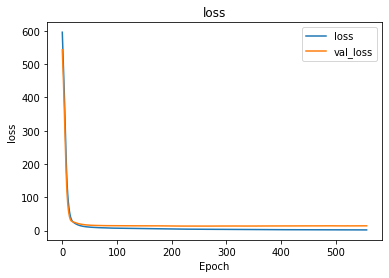

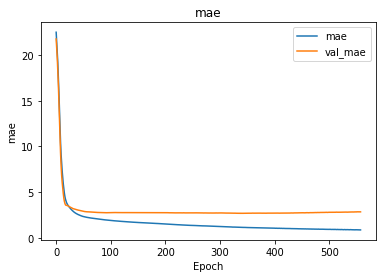

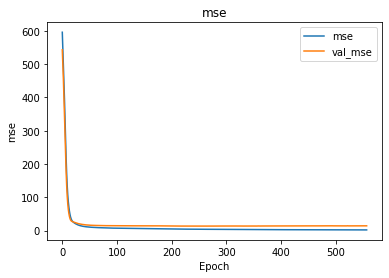

339/339 [==============================] - 0s 50us/sample - loss: 4.3810 - mae: 1.3077 - mse: 4.3810
Train :evaluate score =  [4.381045237403352, 1.3076994, 4.3810453]
167/167 [==============================] - 0s 62us/sample - loss: 16.7311 - mae: 2.6930 - mse: 16.7311
Test :evaluate score =  [16.73106581293894, 2.6930017, 16.731066]

The model performance for  training  set
--------------------------------------
RMSE is 2.093094712766089
R2 score is 0.9502969326739534

The model performance for  testing  set
--------------------------------------
RMSE is 4.090362461866664
R2 score is 0.7789192013788051


In [34]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(widthX,)),
    Dense(16, activation='relu'),
    Dense(1)
   ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002) # Default value
model.compile(optimizer=optimizer,loss='mse', metrics =['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=10000,
    shuffle=False,
    validation_split = 0.2,
    verbose=0, callbacks=[early_stop, PrintDot()]
)

plot_Tesor(history.history, "loss")
plot_Tesor(history.history, "mae")
plot_Tesor(history.history, "mse")

model_sum(model, x_train, y_train, "Train")
model_sum(model, x_test,  y_test,  "Test")

y_train_predict = model.predict(x_train)
y_test_predict =  model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

#print_coeff()

## DataSet Preparation (auto-mpq)
 using data from http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

In [13]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_path = keras.utils.get_file("auto-mpg.data2", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "modelyear", "origin"]

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
dataset = raw_dataset.dropna().copy()


dataset = pd.get_dummies(dataset, prefix='origin', prefix_sep='_',  columns=['origin'])
dataset.rename(columns = {'origin_1':'USA', 'origin_2': "Europe", "origin_3": "Japan"}, inplace = True) 


XNames = [x for x in dataset.columns if x != "mpg"]
df_y = dataset["mpg"]           #series
df_x = dataset[XNames]

#Split the data into 80% training and 20% testing data
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

x_train_columns = list(x_train.columns)

from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler( )
x_train_np = scaler.fit_transform( x_train ) #fit and then transform
x_test_np  = scaler.transform ( x_test )     #transform

x_train = pd.DataFrame(x_train_np,  columns=x_train.columns)
x_test  = pd.DataFrame(x_test_np,  columns=x_train.columns)

x_train.head()


2.1.0


,cylinders,displacement,horsepower,weight,acceleration,modelyear,USA,Europe,Japan
0,-0.886314,-0.829643,-0.466844,-0.432967,1.094827,1.620831,0.735647,-0.411877,-0.509525
1,-0.886314,-0.877324,-0.518837,-0.641029,0.010943,-0.042319,-1.359348,2.427908,-0.509525
2,-0.886314,-0.743818,0.157070,-0.163433,0.010943,-0.873895,-1.359348,2.427908,-0.509525
3,-0.886314,-0.963149,-0.778801,-1.019323,-0.268769,1.066448,-1.359348,2.427908,-0.509525
4,1.424276,1.010830,1.014952,1.032923,-1.037977,0.234872,0.735647,-0.411877,-0.509525


### By LinearRegression from sklearn

In [30]:
#Initialize the linear regression model
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
print(type(lin_model.intercept_))
print(type(lin_model.coef_.flatten()))
#Print the coefecients/weights for each feature/column of our model
#a = list(list(lin_model.intercept_) + list(lin_model.coef_.flatten()))
[lin_model.intercept_]

coefDataFrame = pd.DataFrame( zip( ["intecept"] +  x_train_columns, 
                                   list([lin_model.intercept_] + list(lin_model.coef_.flatten()))
                                   ),
                              columns=['feature', 'coef'])

print("regression cooefficients:\n")
print(coefDataFrame)

def linear_Reg_report(dataset_type, predict_Y, actual_Y):
    rmse = (np.sqrt(mean_squared_error(actual_Y, predict_Y)))
    r2 = r2_score(actual_Y, predict_Y)

    print("\nThe model performance for ",  dataset_type, " set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))


y_train_predict = lin_model.predict(x_train)
y_test_predict =  lin_model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

<class 'numpy.float64'>
<class 'numpy.ndarray'>
regression cooefficients:

        feature       coef
0      intecept  23.561069
1     cylinders  -0.678445
2  displacement   2.414703
3    horsepower  -1.203668
4        weight  -5.353165
5  acceleration   0.218716
6     modelyear   2.751138
7           USA  -0.927927
8        Europe   0.524889
9         Japan   0.638039

The model performance for  training  set
--------------------------------------
RMSE is 3.317928715009621
R2 score is 0.8297695220430706

The model performance for  testing  set
--------------------------------------
RMSE is 3.278363661893737
R2 score is 0.7964817032975607


### By statsmodels

https://www.statsmodels.org/stable/regression.html

In [35]:
import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices

X = sm.add_constant(x_train) # adding a constant

sm_model = sm.OLS(y_train.values, X).fit()
sm_model_summary = sm_model.summary()
print(sm_model_summary)

sm_params = pd.DataFrame(
     {"feature": ["intecept"] +  x_train_columns, 
       "coef"  : sm_model.params.values
     },
     columns=['feature', 'coef'])

    
print(sm_params)


##########################################################################
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("try no-intercept using LinearRegresson")
lin_model2 = LinearRegression(normalize=False, fit_intercept=False)
lin_model2.fit( X  , y_train.values )
print("\n", lin_model2.coef_, "\n")




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     154.2
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.08e-92
Time:                        17:52:07   Log-Likelihood:                -685.99
No. Observations:                 262   AIC:                             1390.
Df Residuals:                     253   BIC:                             1422.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.5611      0.209    112.951   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### By Spark ML

In [37]:
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.context import SparkContext

globs = globals()
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
sc = spark.sparkContext

#import data from previuos session, x_train, x_test, y_train, y_test
xx_train =  x_train.copy()
xx_train["Y"] = y_train.values
xx_test =  x_test.copy()
xx_test["Y"] = y_test.values

x_train_sp = spark.createDataFrame(xx_train)
x_test_sp  = spark.createDataFrame(xx_test)

##### INPUT FOR SPARK
# Spark ML’s algorithms expect the data to be represented in two columns: Features and Labels. 
# 1. Features is an array of data points of all the features to be used for prediction. 
# 2. Labels contain the output label for each data point.

# To create a features array, import the VectorAssembler class and pass in a list of the feature column names.
from pyspark.ml.feature import VectorAssembler
feature_columns = x_train_sp.columns[:-1]   # do not include "Y" column (which is the last one)
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
x_train_sp = assembler.transform(x_train_sp)
#x_train_sp["label"] = y_train.values
print(x_train_sp.show(5))

from pyspark.ml.regression import LinearRegression
# Defining the algorithm variable. We need to specify the name of the features column and the labels column.
algorithm = LinearRegression(featuresCol="features", labelCol="Y")

model_spark = algorithm.fit(x_train_sp)

print("Intercept", model_spark.intercept, "\n",
      "Coefficient: ", model_spark.coefficients)


# Evaluating Model Performance
x_test_sp = assembler.transform(x_test_sp)

evaluation_summary = model_spark.evaluate(x_train_sp)
print("TRAINING ------------------------------------")
print("MAE: ", evaluation_summary.meanAbsoluteError)
print("RMSE: ", evaluation_summary.rootMeanSquaredError)
print("R2: ", evaluation_summary.r2)

evaluation_summary = model_spark.evaluate(x_test_sp)
print("TESTING -------------------------------------")
print("MAE: ", evaluation_summary.meanAbsoluteError)
print("RMSE: ", evaluation_summary.rootMeanSquaredError)
print("R2: ", evaluation_summary.r2)

+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+----+--------------------+
|          cylinders|       displacement|          horsepower|              weight|        acceleration|           modelyear|                USA|            Europe|              Japan|   Y|            features|
+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+----+--------------------+
|-0.8863143793701866|-0.8296431562054152|-0.46684421580103214|-0.43296721094833673|   1.094826603266538|  1.6208310048002363| 0.7356469741582816|-0.411877235523957|-0.5095246653650681|27.0|[-0.8863143793701...|
|-0.8863143793701866|-0.8773237973666459| -0.5188370678902439| -0.6410289889452488|0.010942928018997293|-0.04231934738381...|-1.3593476696403026| 2.42790791

### Using Tensorflow
#### Single Layer

2.1.0

..........
..........
..........
..........
..........
..........
..........
....7351


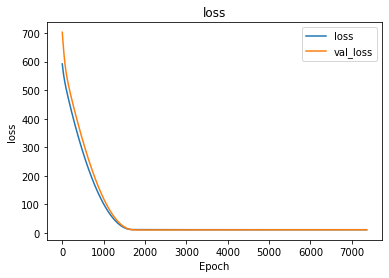

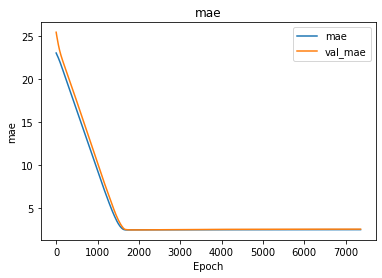

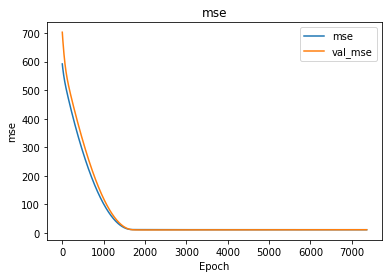

262/262 [==============================] - 0s 49us/sample - loss: 11.3198 - mae: 2.5440 - mse: 11.3198
Train :evaluate score =  [11.319802175041373, 2.5439894, 11.319802]
130/130 [==============================] - 0s 81us/sample - loss: 10.9970 - mae: 2.5711 - mse: 10.9970
Test :evaluate score =  [10.996981811523437, 2.571088, 10.996982]

The model performance for  training  set
--------------------------------------
RMSE is 3.3644914019557173
R2 score is 0.8249580825795853

The model performance for  testing  set
--------------------------------------
RMSE is 3.3161697177279867
R2 score is 0.7917606962691646

the coefficient is as the following:
[[-0.9704183 ]
 [ 3.2514017 ]
 [-0.9291459 ]
 [-5.5981717 ]
 [ 0.68760717]
 [ 2.4308262 ]
 [-1.7082008 ]
 [ 0.15439741]
 [ 0.258798  ]]
Bias:  [23.520535]


In [38]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
                                                     
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 1000 == 0: print('')
    if epoch % 100 == 0: print(".", end='')

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

widthX = x_train.shape[1]
#build our model
model = Sequential([
    Dense(1, input_shape=(widthX,), use_bias=True)
   ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002) # Default value
model.compile(optimizer=optimizer,loss='mse', metrics =['mae', 'mse'])

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=10000,
    shuffle=False,
    validation_split = 0.2,
    verbose=0, callbacks=[early_stop, PrintDot()]
)

minepoch = np.argmin(history.history["loss"])
print(minepoch)

def print_coeff():
  print("\nthe coefficient is as the following:")
  for trainable_variable in model.trainable_weights:
    name = trainable_variable.name
    values =  trainable_variable.read_value().numpy()
    if ("/bias:" in name):
      print("Bias: ", values)
    else:
      print(values)

def plot_Tesor(history, ylabel):
  import matplotlib.pyplot as plt
  plt.clf()
  for k in history.keys():
    if k.endswith(ylabel):
      plt.plot(history[k], label=k)
  plt.title(ylabel)
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_Tesor(history.history, "loss")
plot_Tesor(history.history, "mae")
plot_Tesor(history.history, "mse")

def model_sum(model, X, Y, Title="Train"):
  score = model.evaluate(X, Y)
  print(Title, ":evaluate score = ", score)

model_sum(model, x_train, y_train, "Train")
model_sum(model, x_test,  y_test,  "Test")

y_train_predict = model.predict(x_train)
y_test_predict =  model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

print_coeff()

#### Multi-layers (32, 16, 1)



........

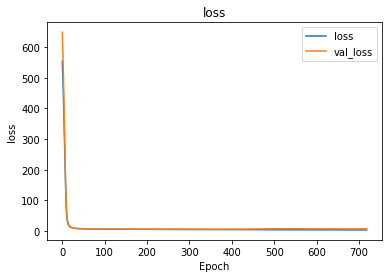

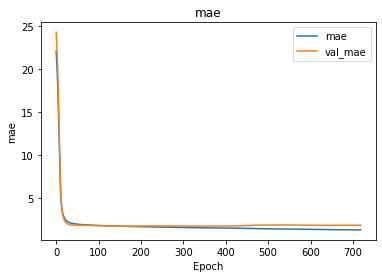

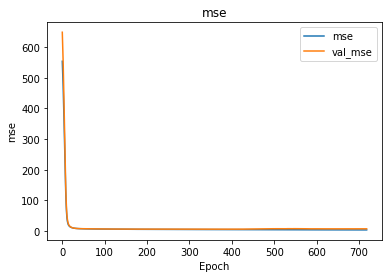

262/262 [==============================] - 0s 56us/sample - loss: 4.2474 - mae: 1.4345 - mse: 4.2474
Train :evaluate score =  [4.2474291806912605, 1.4345496, 4.247429]
130/130 [==============================] - 0s 103us/sample - loss: 8.8245 - mae: 2.2038 - mse: 8.8245
Test :evaluate score =  [8.824503517150879, 2.2038486, 8.824504]

The model performance for  training  set
--------------------------------------
RMSE is 2.0609291782866914
R2 score is 0.9343205734483334

The model performance for  testing  set
--------------------------------------
RMSE is 2.9706065247581255
R2 score is 0.8328988395283053
layer summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
______________________

In [41]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(widthX,)),
    Dense(16, activation='relu'),
    Dense(1)
   ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002) # Default value
model.compile(optimizer=optimizer,loss='mse', metrics =['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=10000,
    shuffle=False,
    validation_split = 0.2,
    verbose=0, callbacks=[early_stop, PrintDot()]
)

plot_Tesor(history.history, "loss")
plot_Tesor(history.history, "mae")
plot_Tesor(history.history, "mse")

model_sum(model, x_train, y_train, "Train")
model_sum(model, x_test,  y_test,  "Test")

y_train_predict = model.predict(x_train)
y_test_predict =  model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

#print_coeff()
print("========================================\nlayer summary")
model.summary()

#### Multi-layers (64, 64, 1)


....

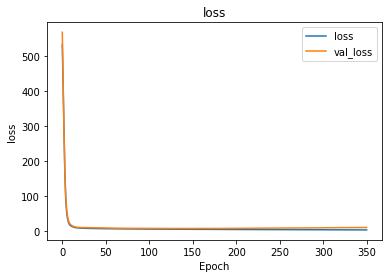

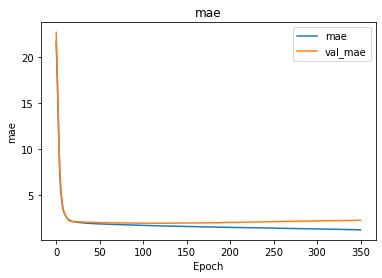

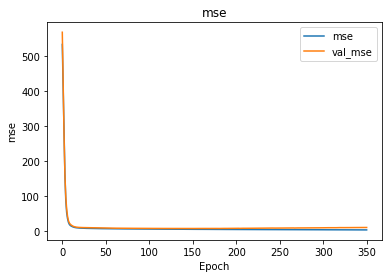

262/262 [==============================] - 0s 58us/sample - loss: 4.2070 - mae: 1.3244 - mse: 4.2070
Train :evaluate score =  [4.206973900321786, 1.3244023, 4.206974]
130/130 [==============================] - 0s 85us/sample - loss: 8.4751 - mae: 2.1943 - mse: 8.4751
Test :evaluate score =  [8.475063052544227, 2.1942704, 8.475064]

The model performance for  training  set
--------------------------------------
RMSE is 2.0510909151888588
R2 score is 0.9349461448362969

The model performance for  testing  set
--------------------------------------
RMSE is 2.9111961313779324
R2 score is 0.8395158539607944
layer summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
________________________

In [42]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(widthX,)),
    Dense(64, activation='relu'),
    Dense(1)
   ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002) # Default value
model.compile(optimizer=optimizer,loss='mse', metrics =['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=10000,
    shuffle=False,
    validation_split = 0.2,
    verbose=0, callbacks=[early_stop, PrintDot()]
)

plot_Tesor(history.history, "loss")
plot_Tesor(history.history, "mae")
plot_Tesor(history.history, "mse")

model_sum(model, x_train, y_train, "Train")
model_sum(model, x_test,  y_test,  "Test")

y_train_predict = model.predict(x_train)
y_test_predict =  model.predict(x_test)

linear_Reg_report("training", y_train_predict, y_train)
linear_Reg_report("testing",  y_test_predict, y_test)

#print_coeff()
print("===================================\nlayer summary")
model.summary()